<a href="https://colab.research.google.com/github/r7sy/SuttonBarto-RL2018-Sols/blob/master/Chapter%2005/Racetrack_Monte_Carlo_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Racetrack : Monte Carlo Control
This notebook contains the solution  to exercise 5.12 from "Reinforcement Learning an Introduction second edition" by Richard S. Sutton and Andrew G. Barto. The exercise is defined in the book as follows:
>*Exercise 5.12: Racetrack (programming)* Consider driving a race car around a turn
like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as
to run o↵ the track. In our simplified racetrack, the car is at one of a discrete set of
grid positions, the cells in the diagram. The velocity is also discrete, a number of grid
cells moved horizontally and vertically per time step. The actions are increments to the
velocity components. Each may be changed by +1, 1, or 0 in each step, for a total of
nine (3 , 3) actions. Both velocity components are restricted to be nonnegative and less
than 5, and they cannot both be zero except at the starting line. Each episode begins
in one of the randomly selected start states with both velocity components zero and
ends when the car crosses the finish line. The rewards are 1 for each step until the car
crosses the finish line. If the car hits the track boundary, it is moved back to a random
position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car’s location at each time step, check to see if
the projected path of the car intersects the track boundary. If it intersects the finish line,
the episode ends; if it intersects anywhere else, the car is considered to have hit the track
boundary and is sent back to the starting line. To make the task more challenging, with
probability 0.1 at each time step the velocity increments are both zero, independently of
the intended increments. Apply a Monte Carlo control method to this task to compute
the optimal policy from each starting state. Exhibit several trajectories following the
optimal policy (but turn the noise off for these trajectories).

The notebook implements the On-policy first-visit and every-vist Monte Carlo control algorithms described on page 101 of the book.

Note:  $R_t$ is stored at index $t-1$ for the convenience of implementation.

In [0]:
import numpy as np
import random as rand
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
class Racetrack:
  
  def __init__(self,padding=5,number_of_starting_positions=5,
               number_of_finishing_positions=5,shape=(20,20),noise=0.1):

    self.padding=padding
    self.number_of_starting_positions=number_of_starting_positions
    self.number_of_finishing_positions=number_of_finishing_positions
    self.racetrack=np.ones(shape=shape)
    self.noise=noise
    self.racetrack[self.padding:self.padding+self.number_of_starting_positions,
                   self.padding:-(self.padding)]=0
    self.racetrack[self.padding:,
                   -(self.padding+self.number_of_finishing_positions):-(self.padding)]=0
    self.goToStartingState()
    
    for i in range(self.padding):
      self.racetrack[i,self.padding+1-i:-(self.padding+i)]=0
  
  def visualizeTrajectory(self,states=np.array([])):
    #intended for short episodes only.
    
    fig=plt.figure()
    plt.imshow(np.transpose((self.racetrack)),origin='lower')
    plt.grid(False)
    plt.axis('off')
    states=np.array(states)
    for i in range(len(states)):
     
      plt.scatter(states[i][0],states[i][1])
    return fig
    
  def goToStartingState(self):
    
    #Samples and sets a new starting position, resets the velocities to zero.
    self.position=np.array([np.random.randint(self.padding,
                                              self.number_of_starting_positions+\
                                              self.padding,dtype=np.int),
                                              self.padding])
    self.velocity=np.array([0,0])
    
    
  def performAction(self,action):
    
    next_vx=self.velocity[0]+action[0]
    next_vy=self.velocity[1]+action[1]
    
    # Velocity can't go over 5
    # Both velocities cannot be 0 at the same time
    # Velocities can't be negative
    # If all conditions are met apply the increments with probability : 1 - noise
    if next_vx<=5 and next_vy<=5 and\
    (next_vx!=0 or next_vy!=0) and\
    next_vx>=0 and next_vy>=0 and\
    np.random.uniform()>self.noise :
      self.velocity[0]+=action[0]
      self.velocity[1]+=action[1]
      
    next_x=self.position[0]+self.velocity[0]
    next_y=self.position[1]+self.velocity[1]
    
    # If the projected position intersects boundaries, go to starting position. 
    if next_x>=self.racetrack.shape[0] or\
       next_y>=self.racetrack.shape[1] or\
       self.racetrack[next_x,next_y]==1:
      
      self.goToStartingState()
      return self.position,self.velocity,-1
    
    
    self.position[0]+=self.velocity[0]
    self.position[1]+=self.velocity[1]
    
    # Return reward 0 if the car reached the finish line
    if self.position[0]==self.racetrack.shape[0]-1:
      self.goToStartingState()
      return (next_x,next_y),(next_vx,next_vy),0
      
    
    
    
    return self.position,self.velocity,-1
    

In [0]:
class MonteCarloAgent(ABC):
  def __init__(self,track,gamma=0.9):
    self.track=track
    # Optimistic values of q to encourage exploration
    self.q_values=np.zeros(self.track.racetrack.shape+(6,6,3,3))
    self.number_of_returns_for_pair =np.zeros(shape=self.track.racetrack.shape+(6,6,3,3))
    self.gamma=gamma
    self.action_indices=[]
    for i in range(3):
      for j in range(3):
        self.action_indices.append(np.array([i,j]))
        
  def epsilonGreedy(self,epsilon,state):
    rand_number=np.random.uniform()
    if rand_number>=epsilon:
      greedy_action=self.action_indices[np.argmax(self.q_values[state[0],
                                                                state[1],
                                                                state[2],
                                                                state[3],
                                                                :,:])]
      return greedy_action
    return self.action_indices[np.random.randint(0,len(self.action_indices))]



  def generateEpisode(self,epsilon):
    states=[]
    rewards=[]
    actions=[]
    i=0
    while True:
      states.append(np.append(self.track.position,self.track.velocity,axis=0))

      i+=1
      action_index=self.epsilonGreedy(epsilon,
                                      np.concatenate([self.track.position,\
                                                      self.track.velocity]))
      action = action_index-1
      position,velocity,reward=self.track.performAction(action)
      actions.append(action_index)
      rewards.append(reward)
      if reward==0:
        states.append(np.append(position,velocity,axis=0))
        break
      if False and i>100:
        break
    return states,rewards,actions
  @abstractmethod
  def policyControl(self,number_of_episodes,epsilon):
    pass
      
class FirstVisitMCAgent(MonteCarloAgent):
    
    def policyControl(self,number_of_episodes,epsilon):
      episode_lens=np.zeros(number_of_episodes)
      for i in range(number_of_episodes):

        states,rewards,actions=self.generateEpisode(epsilon)
        episode_lens[i]=len(states)
        g=0.0
        visited_pairs=[]
        for t in range(len(states)-1):
          visited_pairs.append(list(np.append(states[t],actions[t],axis=0)))
          
        for t in reversed(range(len(states)-1)):
          g=self.gamma*g+rewards[t]

          if  list(np.append(states[t],actions[t],axis=0))\
              not in visited_pairs[0:t]:

            index=tuple(np.append(states[t],actions[t],axis=0))
            self.number_of_returns_for_pair[index]+=1
            n=self.number_of_returns_for_pair[index]
            self.q_values[index]+=(1/n)*(g-self.q_values[index])
      return episode_lens
    
class EveryVisitMCAgent(MonteCarloAgent):
    
    def policyControl(self,number_of_episodes,epsilon):
      episode_lens=np.zeros(number_of_episodes)
      for i in range(number_of_episodes):

        states,rewards,actions=self.generateEpisode(epsilon)
        episode_lens[i]=len(states)
        g=0.0
        
        for t in reversed(range(len(states)-1)):
          g=self.gamma*g+rewards[t]
          index=tuple(np.append(states[t],actions[t],axis=0))
          self.number_of_returns_for_pair[index]+=1
          n=self.number_of_returns_for_pair[index]
          self.q_values[index]+=(1/n)*(g-self.q_values[index])
      return episode_lens


Let's define and visualize a racetrack with 5 possible starting points and 5 possible finishing points.

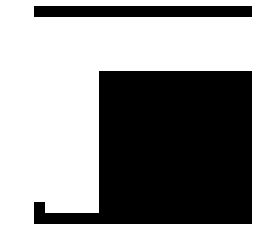

In [4]:
track= Racetrack(padding=1,number_of_finishing_positions=5,
                 number_of_starting_positions=5,noise=0.1)
track.visualizeTrajectory([]);

We run two MC control agents for 100000 episodes, one does first-visit updates and the other does every-visit updates

In [0]:
episodes_num=100000

fv_agent= FirstVisitMCAgent(track)
ev_agent= EveryVisitMCAgent(track)
ep_lens_fv=fv_agent.policyControl(episodes_num,0.3)
ep_lens_ev=ev_agent.policyControl(episodes_num,0.3)



    

We remove the noise from the track


In [0]:
track.noise=0.0



A few episodes generated using the policy learned by the  first-visit MC control agent, exploration is turned off for these episodes


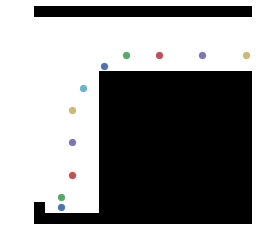

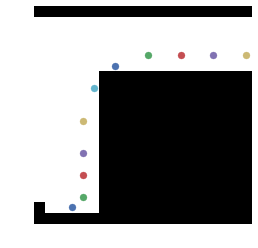

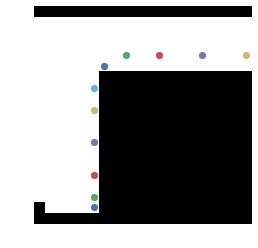

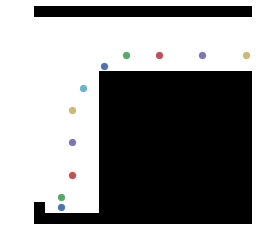

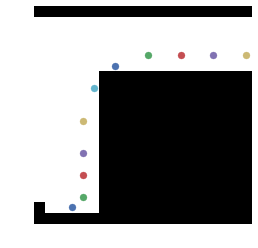

In [7]:
for i in range(5):
  states,rewards,actions=fv_agent.generateEpisode(0.0)
  track.visualizeTrajectory(states);

A few episodes generated using the policy learned by the  every-visit MC control agent, exploration is turned off for these episodes


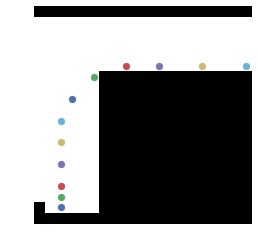

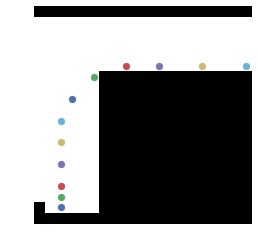

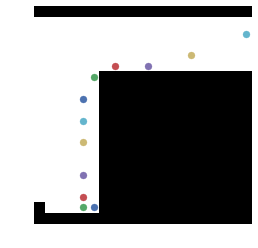

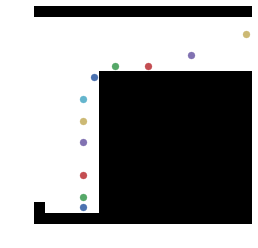

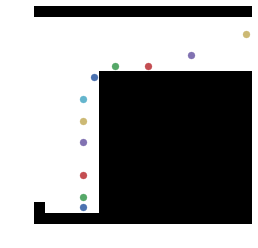

In [8]:
for i in range(5):
  states,rewards,actions=ev_agent.generateEpisode(0.0)
  track.visualizeTrajectory(states);

Let's try a more difficult track, one with only 2 possible finishing points.

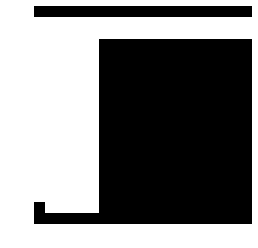

In [9]:
track= Racetrack(padding=1,number_of_finishing_positions=2,
                 number_of_starting_positions=5,noise=0.1)
track.visualizeTrajectory([]);

In [0]:
episodes_num=100000

fv_agent= FirstVisitMCAgent(track)
ev_agent= EveryVisitMCAgent(track)
ep_lens_fv=fv_agent.policyControl(episodes_num,0.3)
ep_lens_ev=ev_agent.policyControl(episodes_num,0.3)

In [0]:
track.noise=0.0



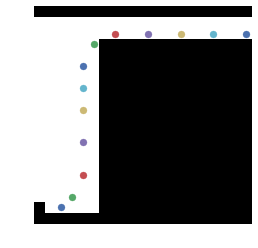

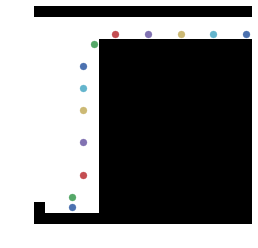

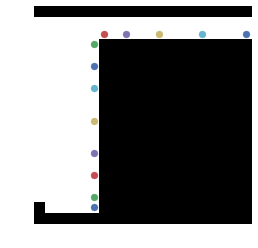

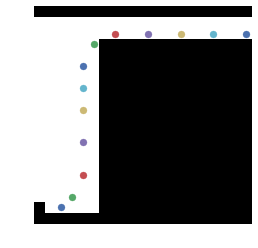

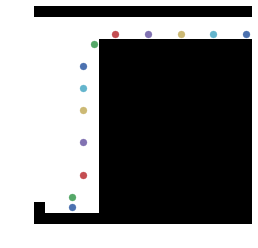

In [12]:
for i in range(5):
  states,rewards,actions=fv_agent.generateEpisode(0.0)
  track.visualizeTrajectory(states);

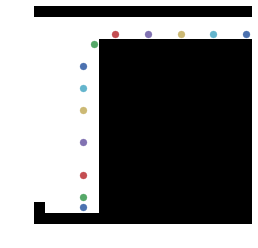

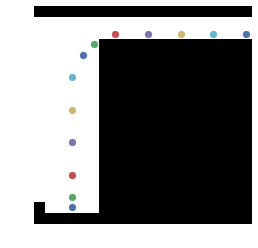

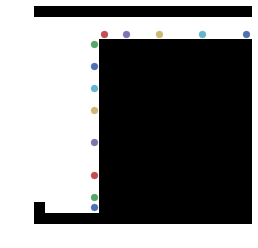

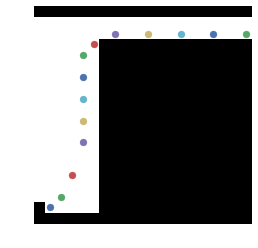

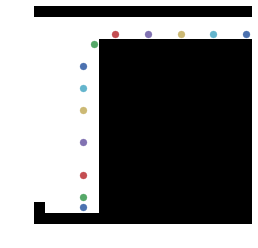

In [13]:
for i in range(5):
  states,rewards,actions=ev_agent.generateEpisode(0.0)
  track.visualizeTrajectory(states);